# Testing compatability of `ddls` with `rllib`

In [13]:
%load_ext autoreload
from ddls.environments.job_placing.job_placing_all_nodes_environment import JobPlacingAllNodesEnvironment
from ddls.devices.processors.gpus.A100 import A100
from ddls.distributions.uniform import Uniform
from ddls.dgl_tests.rllib_model_test import GNNPolicy
from ddls.plotting.plotting import plot_line

import ray
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print
ray.shutdown()
ray.init()

from ray.rllib.models import ModelCatalog
from ray.rllib.agents import ppo


from omegaconf import OmegaConf
from IPython.display import display
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Register the custom environment with `ray`

In [14]:
register_env('job_placing_all_nodes_environment', lambda env_config: JobPlacingAllNodesEnvironment(**env_config))

### Register the custom model with `rllib`

In [15]:
ModelCatalog.register_custom_model('my_model', GNNPolicy)

### Load `rllib` config

In [16]:
# # load config
# config = OmegaConf.load('configs/ddls_job_placing_rllib.yaml')
# print(OmegaConf.to_yaml(config))

# # convert config to dict so that is comparible with rllib
# config = OmegaConf.to_container(config, resolve=False)
# print(config)

In [17]:
%autoreload
node_config = {'type_1':
                  {
                      'num_nodes': 16,
                      'workers_config': 
                          [
                              {
                               'num_workers': 4,
                               'worker': A100
                              }
                          ]
                  }
              }

topology_config = {'type':
                      'torus',
                   'kwargs':
                      {
                          'x_dims': 4,
                          'y_dims': 4
                      }
                  }

jobs_config = {'path_to_files': '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid',
               'job_interarrival_time_dist': Uniform(min_val=1, max_val=1000),
               'max_files': 1,
               'job_sampling_mode': 'remove'}


env_config = {'node_config': node_config,
              'topology_config': topology_config,
              'jobs_config': jobs_config,
              'reward_function': 'mean_job_completion_time'}


rllib_config = {
    
    'seed': 0,
    
    'env': 'job_placing_all_nodes_environment',
    
    'env_config': env_config,
    
    'batch_mode': 'complete_episodes',
    'train_batch_size': 128,
    'sgd_minibatch_size': 128
        
    
}

# print(OmegaConf.to_yaml(rllib_config))
print(rllib_config)

{'seed': 0, 'env': 'job_placing_all_nodes_environment', 'env_config': {'node_config': {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}, 'topology_config': {'type': 'torus', 'kwargs': {'x_dims': 4, 'y_dims': 4}}, 'jobs_config': {'path_to_files': '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid', 'job_interarrival_time_dist': <ddls.distributions.uniform.Uniform object at 0x7f461854deb0>, 'max_files': 1, 'job_sampling_mode': 'remove'}, 'reward_function': 'mean_job_completion_time'}, 'batch_mode': 'complete_episodes', 'train_batch_size': 128, 'sgd_minibatch_size': 128}


### Initialise an `rllib` epoch loop

In [18]:
%autoreload

# load default PPO config and update with custom config params
ppo_config = ppo.DEFAULT_CONFIG.copy()
ppo_config.update(rllib_config)
print(f'Config:\n{ppo_config}')

# initialise rllib trainer
epoch_loop = ppo.PPOTrainer(config=ppo_config)
print('\nInitialised trainer.')

2022-04-13 15:15:38,760	WARNING ppo.py:223 -- `train_batch_size` (128) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 64.


Config:
{'num_workers': 2, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 200, 'batch_mode': 'complete_episodes', 'gamma': 0.99, 'lr': 5e-05, 'train_batch_size': 128, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, '_disable_action_flattening': False, 'fcnet_hiddens': [256, 256], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_us

2022-04-13 15:15:48,222	WARNING util.py:55 -- Install gputil for GPU system monitoring.



Initialised trainer.


### Run `rllib` on the `ddls` environment

In [19]:
%autoreload

agent_name = 'PPO'
num_epochs = 50
rl_training_stats = defaultdict(lambda: [])
for epoch in range(num_epochs):
    print(f'\n------- Epoch {epoch+1} of {num_epochs} -------')
    result = epoch_loop.train()
    
    # print epoch data
    print(pretty_print(result))
    
    # save epoch data
    for key, val in result['hist_stats'].items():
        rl_training_stats[key].extend(val)
    for _ in range(len(val)):
        rl_training_stats['seed'].append(result['config']['seed'])
        rl_training_stats['agent'].append(agent_name)
        rl_training_stats['epoch'].append(epoch)
        
# display(pd.DataFrame(rl_training_stats))


------- Epoch 1 of 50 -------


2022-04-13 15:15:52,616	WARNING ppo.py:162 -- The magnitude of your environment rewards are more than 764.0x the scale of `vf_clip_param`. This means that it will take more than 764.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


agent_timesteps_total: 128
custom_metrics: {}
date: 2022-04-13_15-15-52
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -6328.0
episode_reward_mean: -7637.4375
episode_reward_min: -37420.0
episodes_this_iter: 128
episodes_total: 128
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 4.999999873689376e-05
        entropy: 4.129570960998535
        entropy_coeff: 0.0
        kl: 0.04968668892979622
        model: {}
        policy_loss: -0.08485686033964157
        total_loss: 76172248.0
        vf_explained_var: 7.947286384535346e-09
        vf_loss: 76172248.0
  num_agent_steps_sampled: 128
  num_agent_steps_trained: 128
  num_steps_sampled: 128
  num_steps_trained: 128
  num_steps_trained_this_iter: 128
iterations_since_restore: 1
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator

2022-04-13 15:15:56,561	WARNING ppo.py:162 -- The magnitude of your environment rewards are more than 699.0x the scale of `vf_clip_param`. This means that it will take more than 699.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


agent_timesteps_total: 256
custom_metrics: {}
date: 2022-04-13_15-15-56
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -6992.390625
episode_reward_min: -20604.0
episodes_this_iter: 128
episodes_total: 256
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.30000001192092896
        cur_lr: 4.999999873689376e-05
        entropy: 4.010725498199463
        entropy_coeff: 0.0
        kl: 0.04195340350270271
        model: {}
        policy_loss: -0.10445408523082733
        total_loss: 54481940.0
        vf_explained_var: -3.1789145538141383e-08
        vf_loss: 54481940.0
  num_agent_steps_sampled: 256
  num_agent_steps_trained: 256
  num_steps_sampled: 256
  num_steps_trained: 256
  num_steps_trained_this_iter: 128
iterations_since_restore: 2
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator

2022-04-13 15:16:00,429	WARNING ppo.py:162 -- The magnitude of your environment rewards are more than 664.0x the scale of `vf_clip_param`. This means that it will take more than 664.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


agent_timesteps_total: 384
custom_metrics: {}
date: 2022-04-13_15-16-00
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -6641.640625
episode_reward_min: -20604.0
episodes_this_iter: 128
episodes_total: 384
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.44999998807907104
        cur_lr: 4.999999873689376e-05
        entropy: 3.9034831523895264
        entropy_coeff: 0.0
        kl: 0.026931578293442726
        model: {}
        policy_loss: -0.08096233755350113
        total_loss: 47055792.0
        vf_explained_var: -3.1789145538141383e-08
        vf_loss: 47055792.0
  num_agent_steps_sampled: 384
  num_agent_steps_trained: 384
  num_steps_sampled: 384
  num_steps_trained: 384
  num_steps_trained_this_iter: 128
iterations_since_restore: 3
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimat

2022-04-13 15:16:04,338	WARNING ppo.py:162 -- The magnitude of your environment rewards are more than 621.0x the scale of `vf_clip_param`. This means that it will take more than 621.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


agent_timesteps_total: 512
custom_metrics: {}
date: 2022-04-13_15-16-04
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -6207.515625
episode_reward_min: -8294.0
episodes_this_iter: 128
episodes_total: 512
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.675000011920929
        cur_lr: 4.999999873689376e-05
        entropy: 3.8334100246429443
        entropy_coeff: 0.0
        kl: 0.025932492688298225
        model: {}
        policy_loss: -0.09128186851739883
        total_loss: 40438144.0
        vf_explained_var: -1.1920929132713809e-08
        vf_loss: 40438144.0
  num_agent_steps_sampled: 512
  num_agent_steps_trained: 512
  num_steps_sampled: 512
  num_steps_trained: 512
  num_steps_trained_this_iter: 128
iterations_since_restore: 4
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator:

2022-04-13 15:16:08,108	WARNING ppo.py:162 -- The magnitude of your environment rewards are more than 595.0x the scale of `vf_clip_param`. This means that it will take more than 595.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


agent_timesteps_total: 640
custom_metrics: {}
date: 2022-04-13_15-16-08
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -5948.515625
episode_reward_min: -12480.0
episodes_this_iter: 128
episodes_total: 640
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 4.999999873689376e-05
        entropy: 3.7014236450195312
        entropy_coeff: 0.0
        kl: 0.030831417068839073
        model: {}
        policy_loss: -0.12613268196582794
        total_loss: 39910000.0
        vf_explained_var: -7.947286384535346e-09
        vf_loss: 39910000.0
  num_agent_steps_sampled: 640
  num_agent_steps_trained: 640
  num_steps_sampled: 640
  num_steps_trained: 640
  num_steps_trained_this_iter: 128
iterations_since_restore: 5
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator

2022-04-13 15:16:12,047	WARNING ppo.py:162 -- The magnitude of your environment rewards are more than 610.0x the scale of `vf_clip_param`. This means that it will take more than 610.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


agent_timesteps_total: 768
custom_metrics: {}
date: 2022-04-13_15-16-12
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -6097.9375
episode_reward_min: -37420.0
episodes_this_iter: 128
episodes_total: 768
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 1.5187499523162842
        cur_lr: 4.999999873689376e-05
        entropy: 3.6216893196105957
        entropy_coeff: 0.0
        kl: 0.013129767961800098
        model: {}
        policy_loss: -0.0846531018614769
        total_loss: 50235308.0
        vf_explained_var: 0.0
        vf_loss: 50235308.0
  num_agent_steps_sampled: 768
  num_agent_steps_trained: 768
  num_steps_sampled: 768
  num_steps_trained: 768
  num_steps_trained_this_iter: 128
iterations_since_restore: 6
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator: {}
perf:
  cpu_util_

2022-04-13 15:16:15,820	WARNING ppo.py:162 -- The magnitude of your environment rewards are more than 552.0x the scale of `vf_clip_param`. This means that it will take more than 552.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


agent_timesteps_total: 896
custom_metrics: {}
date: 2022-04-13_15-16-15
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -5518.96875
episode_reward_min: -16212.0
episodes_this_iter: 128
episodes_total: 896
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 1.5187499523162842
        cur_lr: 4.999999873689376e-05
        entropy: 3.4681029319763184
        entropy_coeff: 0.0
        kl: 0.02475162036716938
        model: {}
        policy_loss: -0.14489099383354187
        total_loss: 36743828.0
        vf_explained_var: 9.934107758624577e-09
        vf_loss: 36743828.0
  num_agent_steps_sampled: 896
  num_agent_steps_trained: 896
  num_steps_sampled: 896
  num_steps_trained: 896
  num_steps_trained_this_iter: 128
iterations_since_restore: 7
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator: {

2022-04-13 15:16:19,792	WARNING ppo.py:162 -- The magnitude of your environment rewards are more than 518.0x the scale of `vf_clip_param`. This means that it will take more than 518.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


agent_timesteps_total: 1024
custom_metrics: {}
date: 2022-04-13_15-16-19
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -5180.9375
episode_reward_min: -8740.0
episodes_this_iter: 128
episodes_total: 1024
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 2.278125047683716
        cur_lr: 4.999999873689376e-05
        entropy: 3.1546967029571533
        entropy_coeff: 0.0
        kl: 0.028446700423955917
        model: {}
        policy_loss: -0.17633725702762604
        total_loss: 33649876.0
        vf_explained_var: 1.9868215961338365e-09
        vf_loss: 33649876.0
  num_agent_steps_sampled: 1024
  num_agent_steps_trained: 1024
  num_steps_sampled: 1024
  num_steps_trained: 1024
  num_steps_trained_this_iter: 128
iterations_since_restore: 8
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimat

2022-04-13 15:16:23,434	WARNING ppo.py:162 -- The magnitude of your environment rewards are more than 448.0x the scale of `vf_clip_param`. This means that it will take more than 448.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


agent_timesteps_total: 1152
custom_metrics: {}
date: 2022-04-13_15-16-23
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -4476.515625
episode_reward_min: -10370.0
episodes_this_iter: 128
episodes_total: 1152
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 3.417187452316284
        cur_lr: 4.999999873689376e-05
        entropy: 2.92168927192688
        entropy_coeff: 0.0
        kl: 0.023041091859340668
        model: {}
        policy_loss: -0.1913491189479828
        total_loss: 29153144.0
        vf_explained_var: 0.0
        vf_loss: 29153144.0
  num_agent_steps_sampled: 1152
  num_agent_steps_trained: 1152
  num_steps_sampled: 1152
  num_steps_trained: 1152
  num_steps_trained_this_iter: 128
iterations_since_restore: 9
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator: {}
perf:
  cpu_

2022-04-13 15:16:26,779	WARNING ppo.py:162 -- The magnitude of your environment rewards are more than 408.0x the scale of `vf_clip_param`. This means that it will take more than 408.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


agent_timesteps_total: 1280
custom_metrics: {}
date: 2022-04-13_15-16-26
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -4076.203125
episode_reward_min: -10370.0
episodes_this_iter: 128
episodes_total: 1280
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 5.125781059265137
        cur_lr: 4.999999873689376e-05
        entropy: 2.687525749206543
        entropy_coeff: 0.0
        kl: 0.017702896147966385
        model: {}
        policy_loss: -0.1830904483795166
        total_loss: 27089274.0
        vf_explained_var: -1.1920929132713809e-08
        vf_loss: 27089274.0
  num_agent_steps_sampled: 1280
  num_agent_steps_trained: 1280
  num_steps_sampled: 1280
  num_steps_trained: 1280
  num_steps_trained_this_iter: 128
iterations_since_restore: 10
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_esti

2022-04-13 15:16:29,724	WARNING ppo.py:162 -- The magnitude of your environment rewards are more than 346.0x the scale of `vf_clip_param`. This means that it will take more than 346.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


agent_timesteps_total: 1408
custom_metrics: {}
date: 2022-04-13_15-16-29
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -3458.984375
episode_reward_min: -7466.0
episodes_this_iter: 128
episodes_total: 1408
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 5.125781059265137
        cur_lr: 4.999999873689376e-05
        entropy: 2.292794704437256
        entropy_coeff: 0.0
        kl: 0.017538832500576973
        model: {}
        policy_loss: -0.18065841495990753
        total_loss: 22424276.0
        vf_explained_var: -8.742014756535355e-08
        vf_loss: 22424276.0
  num_agent_steps_sampled: 1408
  num_agent_steps_trained: 1408
  num_steps_sampled: 1408
  num_steps_trained: 1408
  num_steps_trained_this_iter: 128
iterations_since_restore: 11
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estim

2022-04-13 15:16:32,639	WARNING ppo.py:162 -- The magnitude of your environment rewards are more than 278.0x the scale of `vf_clip_param`. This means that it will take more than 278.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


agent_timesteps_total: 1536
custom_metrics: {}
date: 2022-04-13_15-16-32
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -2781.984375
episode_reward_min: -8154.0
episodes_this_iter: 128
episodes_total: 1536
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 5.125781059265137
        cur_lr: 4.999999873689376e-05
        entropy: 1.9318517446517944
        entropy_coeff: 0.0
        kl: 0.01477688830345869
        model: {}
        policy_loss: -0.16661851108074188
        total_loss: 17939284.0
        vf_explained_var: 1.5894572769070692e-08
        vf_loss: 17939286.0
  num_agent_steps_sampled: 1536
  num_agent_steps_trained: 1536
  num_steps_sampled: 1536
  num_steps_trained: 1536
  num_steps_trained_this_iter: 128
iterations_since_restore: 12
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estim

2022-04-13 15:16:35,575	WARNING ppo.py:162 -- The magnitude of your environment rewards are more than 233.0x the scale of `vf_clip_param`. This means that it will take more than 233.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


agent_timesteps_total: 1664
custom_metrics: {}
date: 2022-04-13_15-16-35
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -2330.015625
episode_reward_min: -12196.0
episodes_this_iter: 128
episodes_total: 1664
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 5.125781059265137
        cur_lr: 4.999999873689376e-05
        entropy: 1.6328092813491821
        entropy_coeff: 0.0
        kl: 0.011669540777802467
        model: {}
        policy_loss: -0.14713113009929657
        total_loss: 15635456.0
        vf_explained_var: -4.7683716530855236e-08
        vf_loss: 15635456.0
  num_agent_steps_sampled: 1664
  num_agent_steps_trained: 1664
  num_steps_sampled: 1664
  num_steps_trained: 1664
  num_steps_trained_this_iter: 128
iterations_since_restore: 13
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_es

agent_timesteps_total: 2304
custom_metrics: {}
date: 2022-04-13_15-16-47
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -518.75
episode_reward_min: -7534.0
episodes_this_iter: 128
episodes_total: 2304
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 5.125781059265137
        cur_lr: 4.999999873689376e-05
        entropy: 0.753164529800415
        entropy_coeff: 0.0
        kl: 0.0036525509785860777
        model: {}
        policy_loss: -0.07612427324056625
        total_loss: 3429178.75
        vf_explained_var: 0.0
        vf_loss: 3429178.75
  num_agent_steps_sampled: 2304
  num_agent_steps_trained: 2304
  num_steps_sampled: 2304
  num_steps_trained: 2304
  num_steps_trained_this_iter: 128
iterations_since_restore: 18
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator: {}
perf:
  cpu_ut

agent_timesteps_total: 2944
custom_metrics: {}
date: 2022-04-13_15-16-57
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -613.84375
episode_reward_min: -9562.0
episodes_this_iter: 128
episodes_total: 2944
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 1.2814452648162842
        cur_lr: 4.999999873689376e-05
        entropy: 0.3283741772174835
        entropy_coeff: 0.0
        kl: 0.00524528743699193
        model: {}
        policy_loss: -0.07884608954191208
        total_loss: 4483795.0
        vf_explained_var: 0.0
        vf_loss: 4483795.0
  num_agent_steps_sampled: 2944
  num_agent_steps_trained: 2944
  num_steps_sampled: 2944
  num_steps_trained: 2944
  num_steps_trained_this_iter: 128
iterations_since_restore: 23
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator: {}
perf:
  cpu_u

agent_timesteps_total: 3584
custom_metrics: {}
date: 2022-04-13_15-17-07
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -113.140625
episode_reward_min: -7624.0
episodes_this_iter: 128
episodes_total: 3584
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.08009032905101776
        cur_lr: 4.999999873689376e-05
        entropy: 0.10052083432674408
        entropy_coeff: 0.0
        kl: 0.0005472427583299577
        model: {}
        policy_loss: -0.03510928526520729
        total_loss: 815692.9375
        vf_explained_var: 0.0
        vf_loss: 815692.9375
  num_agent_steps_sampled: 3584
  num_agent_steps_trained: 3584
  num_steps_sampled: 3584
  num_steps_trained: 3584
  num_steps_trained_this_iter: 128
iterations_since_restore: 28
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator: {}
perf

/scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/ray/rllib/utils/metrics/learner_info.py:64: RuntimeWarning: Mean of empty slice
  lambda *s: None if s[0] is None else np.nanmean(s, axis=0),


agent_timesteps_total: 3840
custom_metrics: {}
date: 2022-04-13_15-17-11
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: 0.0
episode_reward_min: 0.0
episodes_this_iter: 128
episodes_total: 3840
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.02002258226275444
        cur_lr: 4.999999873689376e-05
        entropy: 0.06630385667085648
        entropy_coeff: 0.0
        kl: 1.4266291827880195e-06
        model: {}
        policy_loss: -0.019075917080044746
        total_loss: 898.0243530273438
        vf_explained_var: 'null'
        vf_loss: 898.0433959960938
  num_agent_steps_sampled: 3840
  num_agent_steps_trained: 3840
  num_steps_sampled: 3840
  num_steps_trained: 3840
  num_steps_trained_this_iter: 128
iterations_since_restore: 30
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator: {}

agent_timesteps_total: 4480
custom_metrics: {}
date: 2022-04-13_15-17-20
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: 0.0
episode_reward_min: 0.0
episodes_this_iter: 128
episodes_total: 4480
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.0006257056957110763
        cur_lr: 4.999999873689376e-05
        entropy: 0.04628545418381691
        entropy_coeff: 0.0
        kl: 3.970708561951142e-08
        model: {}
        policy_loss: 0.019073383882641792
        total_loss: 899.0274047851562
        vf_explained_var: 'null'
        vf_loss: 899.0084838867188
  num_agent_steps_sampled: 4480
  num_agent_steps_trained: 4480
  num_steps_sampled: 4480
  num_steps_trained: 4480
  num_steps_trained_this_iter: 128
iterations_since_restore: 35
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator: {}

agent_timesteps_total: 5120
custom_metrics: {}
date: 2022-04-13_15-17-30
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: 0.0
episode_reward_min: 0.0
episodes_this_iter: 128
episodes_total: 5120
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 1.9553302990971133e-05
        cur_lr: 4.999999873689376e-05
        entropy: 0.03814343363046646
        entropy_coeff: 0.0
        kl: -6.050024836667944e-08
        model: {}
        policy_loss: -0.03814743831753731
        total_loss: 892.738037109375
        vf_explained_var: 'null'
        vf_loss: 892.7760620117188
  num_agent_steps_sampled: 5120
  num_agent_steps_trained: 5120
  num_steps_sampled: 5120
  num_steps_trained: 5120
  num_steps_trained_this_iter: 128
iterations_since_restore: 40
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator: {

agent_timesteps_total: 5760
custom_metrics: {}
date: 2022-04-13_15-17-39
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: 0.0
episode_reward_min: 0.0
episodes_this_iter: 128
episodes_total: 5760
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 6.110407184678479e-07
        cur_lr: 4.999999873689376e-05
        entropy: 0.028638361021876335
        entropy_coeff: 0.0
        kl: 6.060522395046064e-08
        model: {}
        policy_loss: 0.0
        total_loss: 889.6434936523438
        vf_explained_var: 'null'
        vf_loss: 889.6434936523438
  num_agent_steps_sampled: 5760
  num_agent_steps_trained: 5760
  num_steps_sampled: 5760
  num_steps_trained: 5760
  num_steps_trained_this_iter: 128
iterations_since_restore: 45
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator: {}
perf:
  cpu_uti

agent_timesteps_total: 6400
custom_metrics: {}
date: 2022-04-13_15-17-48
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: 0.0
episode_reward_mean: -50.265625
episode_reward_min: -6434.0
episodes_this_iter: 128
episodes_total: 6400
experiment_id: 6384ae069e884b3081c17490963bbbaa
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 1.9095022452120247e-08
        cur_lr: 4.999999873689376e-05
        entropy: 0.02509303018450737
        entropy_coeff: 0.0
        kl: 0.00019632812472991645
        model: {}
        policy_loss: -0.02495698444545269
        total_loss: 321307.125
        vf_explained_var: 0.0
        vf_loss: 321307.15625
  num_agent_steps_sampled: 6400
  num_agent_steps_trained: 6400
  num_steps_sampled: 6400
  num_steps_trained: 6400
  num_steps_trained_this_iter: 128
iterations_since_restore: 50
node_ip: 128.40.41.23
num_healthy_workers: 2
off_policy_estimator: {}
p

Plotting metric episode_reward


<Figure size 1920x1440 with 0 Axes>

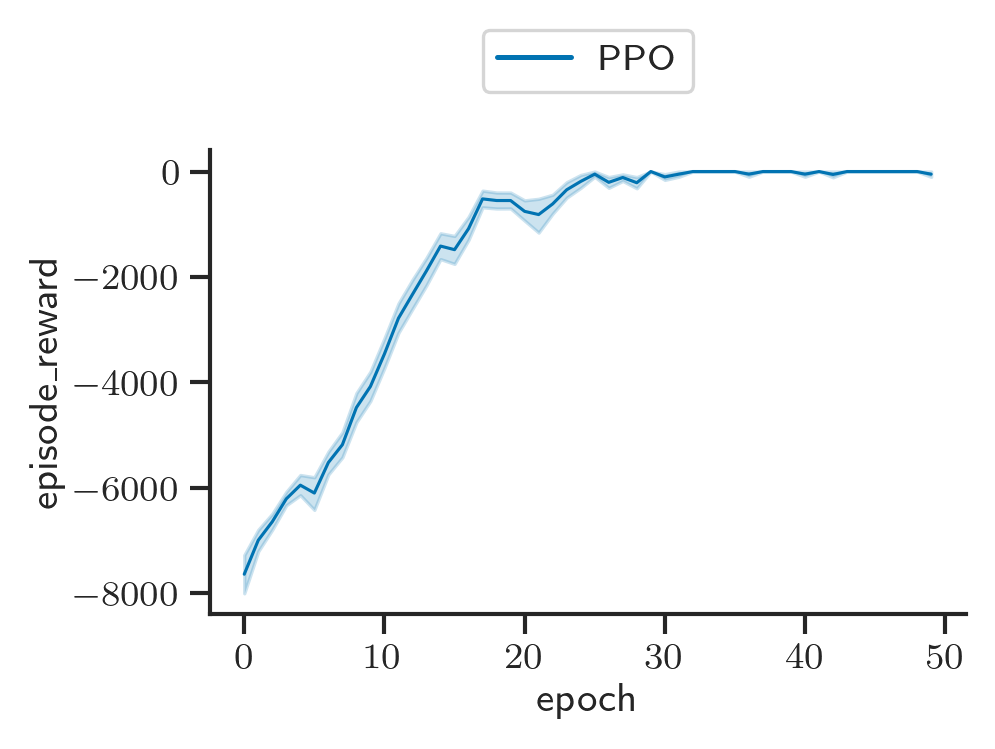

Plotting metric episode_lengths


<Figure size 1920x1440 with 0 Axes>

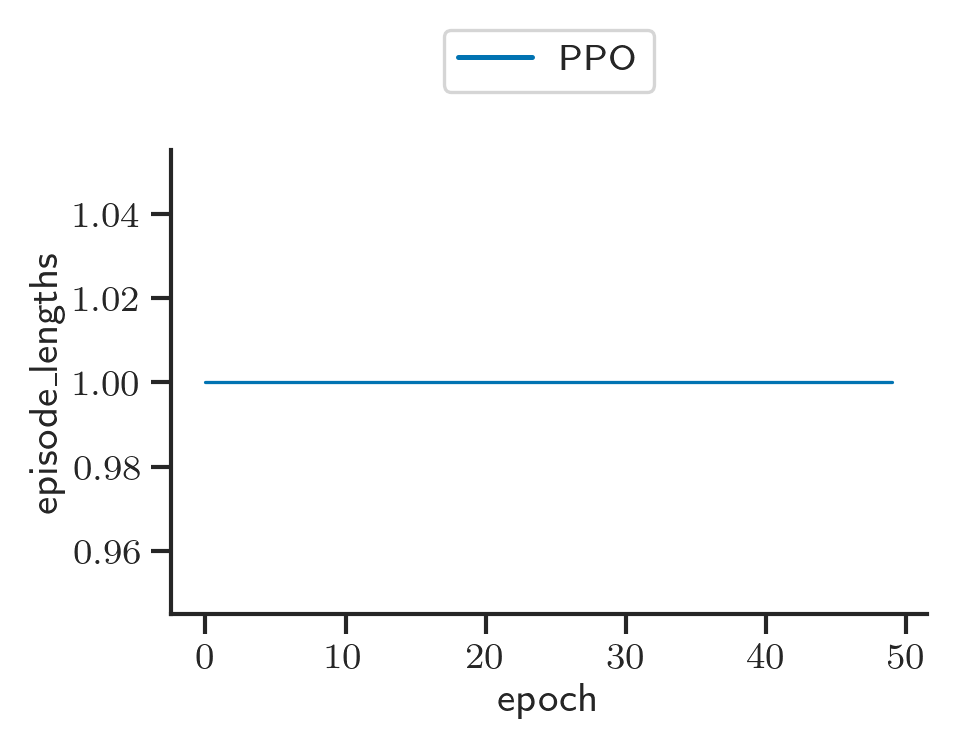

In [20]:
x = 'epoch'
scaling_factor = 1
metrics_to_plot = {'episode_reward', 'episode_lengths'}

for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    fig = plt.figure()
    fig = plot_line(pd.DataFrame(rl_training_stats), 
                    x=x, 
                    y=metric, 
                    hue='agent', 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=False)
#     plt.axhline(y=np.mean(random_baseline_stats[metric]), linestyle='--', color='#a84a32', label='Random')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)
    plt.show()